In [40]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

![pertussis_model.png](figures/pertussis_model.png)

cite from paper: Hethcote, Herbert W. "An age-structured model for pertussis transmission." Mathematical biosciences 145.2 (1997): 89-136.

In [41]:
++(s1, s2) = Symbol(string(s1) * string(s2))

++ (generic function with 1 method)

# 1. Define the components of all the sub-models
## 1.1 Define open sub-model including each stock and its death flow

In [42]:
function fOpenDeaths(s)
    s_Stock = Symbol(s)
    Deaths_s = "Deaths_" ++ s
    v_Deaths_s = "v_Deaths_s" ++ s
    rDeath = :rDeath
    
    Open(
        StockAndFlowF(
            # stocks
            (
                s_Stock => (:F_NONE, Deaths_s, :N)
            ),
            # parameters
            (
                rDeath
            ),
            # dynamic variables
            (
                v_Deaths_s => ((s_Stock, rDeath) => :*)
            ),
            # flows
            (
                Deaths_s => v_Deaths_s
            ),
            # sums
            (
                :N
            )
        ),
        # feet
        foot(Symbol(s),:N,Symbol(s)=>:N)
        
    )
end


fOpenDeaths (generic function with 1 method)

### For example, the deaths sub-model of stock "S" is:

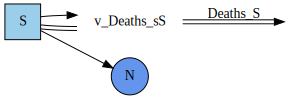

In [43]:
Graph(apex(fOpenDeaths("S")))

## 1.2 Define the SIR sub-model including the flow of new borns to stock S

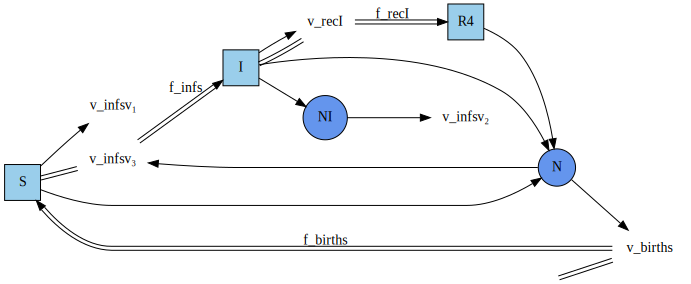

In [44]:
openSIR = Open(
    (@stock_and_flow begin
        :stocks
        S
        I
        R4

        :parameters
        γ
        rBirth
        β

        :dynamic_variables
        v_births = N * rBirth
        v_infsv₁ = S * β
        v_infsv₂ = v_infsv₁ * NI
        v_infsv₃ = v_infsv₂ / N
        v_recI = I * γ

        :flows
        CLOUD => f_births(v_births) => S
        S => f_infs(v_infsv₃) => I
        I => f_recI(v_recI) => R4

        :sums
        N = [S, I, R4]
        NI = [I]



    end),
        # feet
        foot(:S,:N,:S=>:N),
        foot(:I,:N,:I=>:N),
        foot(:R4,:N,:R4=>:N),
        foot((),:NI,())

)
Graph(apex(openSIR))

## 1.3 Define the open sub-model of VRIR, including V1R1ImR4 and V2R2IwR4

In [45]:
# n: string of "1" or "2"
# mw:string of "m" or "w"
function openVRIR(n, mw)
    Vn = "V" ++ n
    f_infVn = "f_infV" ++ n
    v_infVn₁ = ("v_infV" ++ n) ++ raw"\_1"
    v_infVn₂ = ("v_infV" ++ n) ++ raw"\_2"
    v_infVn₃ = ("v_infV" ++ n) ++ raw"\_3"


    
    Rn = "R" ++ n
    f_infRn = "f_infR" ++ n
    v_infRn₁ = ("v_infR" ++ n) ++ raw"\_1"
    v_infRn₂ = ("v_infR" ++ n) ++ raw"\_2"
    v_infRn₃ = ("v_infR" ++ n) ++ raw"\_3"



    Imw = "I" ++ mw
    f_recImw = "f_recI" ++ mw
    v_recImw = "v_recI" ++ mw

    R4 = :R4
    β = :β
    γ = :γ

    Open(
        StockAndFlowF(
            #stocks
            (
                Vn => (:F_NONE, f_infVn, :N),
                Rn => (:F_NONE, f_infRn, :N),
                Imw => ((f_infVn, f_infRn), f_recImw, (:N, :NI)),
                R4 => (f_recImw, :F_NONE, :N)
            ),

            # parameters
            (
                β,
                γ
            ),

            # dynamic variables
            (
                v_infVn₁ => ((Vn, β) => :*),
                v_infVn₂ => ((v_infVn₁, :NI) => :*),
                v_infVn₃ => ((v_infVn₂, :N) => :/),

                v_infRn₁ => ((Rn, β) => :*),
                v_infRn₂ => ((v_infRn₁, :NI) => :*),
                v_infRn₃ => ((v_infRn₂, :N) => :/),

                v_recImw => ((Imw, γ) => :*)
            ),

            # flows
            (
                f_infVn => v_infVn₃,
                f_infRn => v_infRn₃,
                f_recImw => v_recImw
            ),

            # sums
            (
                :N,
                :NI
            )


        ),
        # feet
        foot(Vn, :N, Vn=>:N),
        foot(Imw, :N, Imw=>:N),
        foot(Rn, :N, Rn=>:N),
        foot(R4,:N,R4=>:N),
        foot((),:NI,())
    
    )

end



openVRIR (generic function with 1 method)

### For example, the V1R1ImR4 model is:

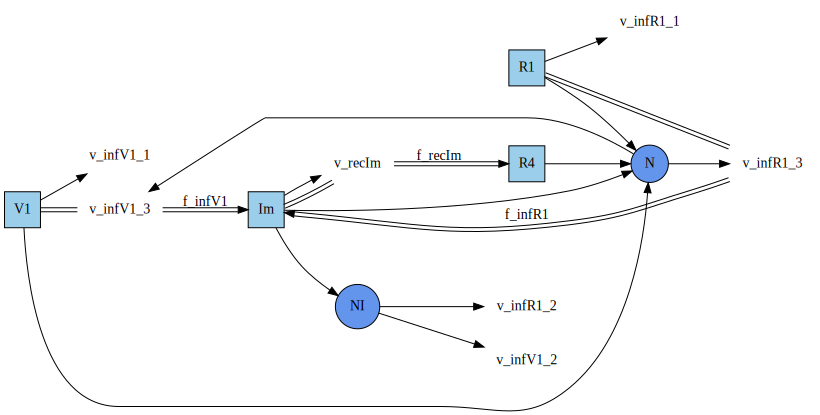

In [46]:
Graph(apex(openVRIR("1","m")))

## 1.4 Define the immunity increase and decrease between two levels of V or R

In [47]:
function fOpenImmunity(us, ds, r)

    us_Stock = Symbol(us)
    ds_Stock = Symbol(ds)
    r_Param = Symbol(r) # r was already a symbol, so this doesn't matter
    

    f_dsWaningImmunity = ("f_" ++ ds) ++ "WaningImmunity"
    f_Vaccus = "f_Vacc" ++ us
    v_Vaccus = "v_Vacc" ++ us

    v_WanImmuds = "v_WanImmu" ++ ds

    vacc = :vacc


    Open(
        StockAndFlowF(
            # stocks
            (
                us_Stock => (f_dsWaningImmunity, f_Vaccus, :N),
                ds_Stock => (f_Vaccus, f_dsWaningImmunity, :N)
            ),
            # parameters
            (
                vacc,
                r_Param
            ),
            # dynamic variables
            (
                v_WanImmuds => ((ds_Stock, r_Param) => :*),
                v_Vaccus => ((us_Stock, vacc) => :*)
            ),
            # flows
            (
                f_dsWaningImmunity => v_WanImmuds,
                f_Vaccus => v_Vaccus
            ),
            # sums
            (
                :N
            )

        ),

            # feet
            foot(Symbol(us),:N,Symbol(us)=>:N),
            foot(Symbol(ds),:N,Symbol(ds)=>:N)

    )


end

fOpenImmunity (generic function with 1 method)

### For example, the sub-model between R1 and R2 is:

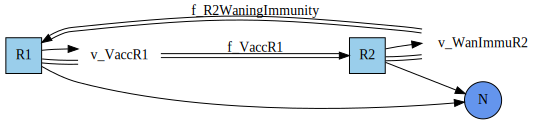

In [48]:
Graph(apex(fOpenImmunity("R1","R2",:α)))

## 1.5 The rest sub-model components
### 1.5.1 The rest sub-model components of new infectious
Including, the new infectious from stock R3 or V3 to R4 

In [49]:
function fOpenR3OrV3ToR4(s)
    s_Stock = Symbol(s)
    
    f_infs = "f_inf" ++ s
    v_infs₁ = ("v_inf" ++ s) ++ raw"\_1"
    v_infs₂ = ("v_inf" ++ s) ++ raw"\_2"
    v_infs₃ = ("v_inf" ++ s) ++ raw"\_3"

    R4 = :R4
    β = :β

    Open(
        StockAndFlowF(
            # stocks
            (
                s_Stock => (:F_NONE, f_infs, :N),
                R4 => (f_infs, :F_NONE, :N)
            ),
            # parameters
            (
                β
            ),
            # dynamic variables
            (
                v_infs₁ => ((s_Stock, β) => :*),
                v_infs₂ => ((v_infs₁, :NI) => :*),
                v_infs₃ => ((v_infs₂, :N) => :/)
            ),
            # flows
            (
                f_infs => v_infs₃
            ),
            # sums
            (
                :N,
                :NI
            )
        ),
   # feet
   foot(Symbol(s),:N,Symbol(s)=>:N),
   foot(:R4,:N,:R4=>:N),
   foot((),:NI,())

    )



end

fOpenR3OrV3ToR4 (generic function with 1 method)

### For example, sub-model of new infectious from Stock V3 to R4

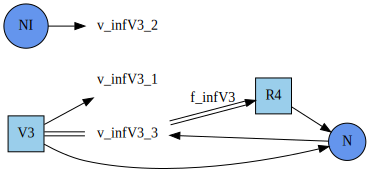

In [50]:
Graph(apex(fOpenR3OrV3ToR4("V3")))

### 1.5.2 The rest sub-model components of waning immunity from Stock R1 to S

In [51]:
OpenR1ToS = Open(
    (@stock_and_flow begin
        :stocks
        R1
        S

        :parameters
        ϵ

        :dynamic_variables
        v_WaningImmunityR1 = R1 * ϵ

        :flows
        R1 => f_WaningImmunityR1(v_WaningImmunityR1) => S

        :sums
        N = [R1, S]
    end),

    foot(:R1,:N,:R1=>:N),
    foot(:S,:N,:S=>:N)


)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAl

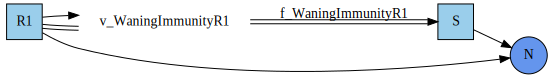

In [52]:
Graph(apex(OpenR1ToS))

# 2. Composition

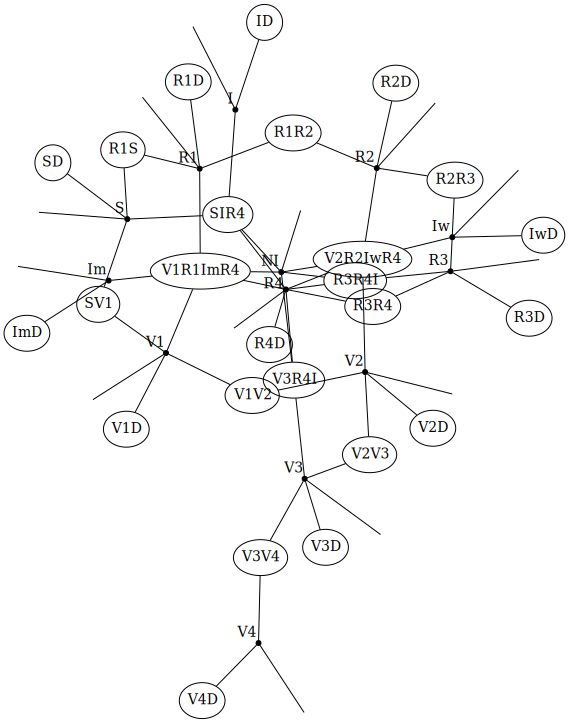

In [53]:
# define the UWD-algebra of Hyperglycemic Model
pertussis_uwd = @relation (S,I,Im,Iw,R1,R2,R3,R4,V1,V2,V3,V4,NI) begin
    SD(S)
    ID(I)
    ImD(Im)
    IwD(Iw)
    R1D(R1)
    R2D(R2)
    R3D(R3)
    R4D(R4)
    V1D(V1)
    V2D(V2)
    V3D(V3)
    V4D(V4)
    SIR4(S,I,R4,NI)
    V1R1ImR4(V1,Im,R1,R4,NI)
    V2R2IwR4(V2,Iw,R2,R4,NI)
    R1R2(R1,R2)
    R2R3(R2,R3)
    R3R4(R3,R4)
    SV1(S,V1)
    V1V2(V1,V2)
    V2V3(V2,V3)
    V3V4(V3,V4)
    V3R4I(V3,R4,NI)
    R3R4I(R3,R4,NI)
    R1S(R1,S)
end;
display_uwd(pertussis_uwd)

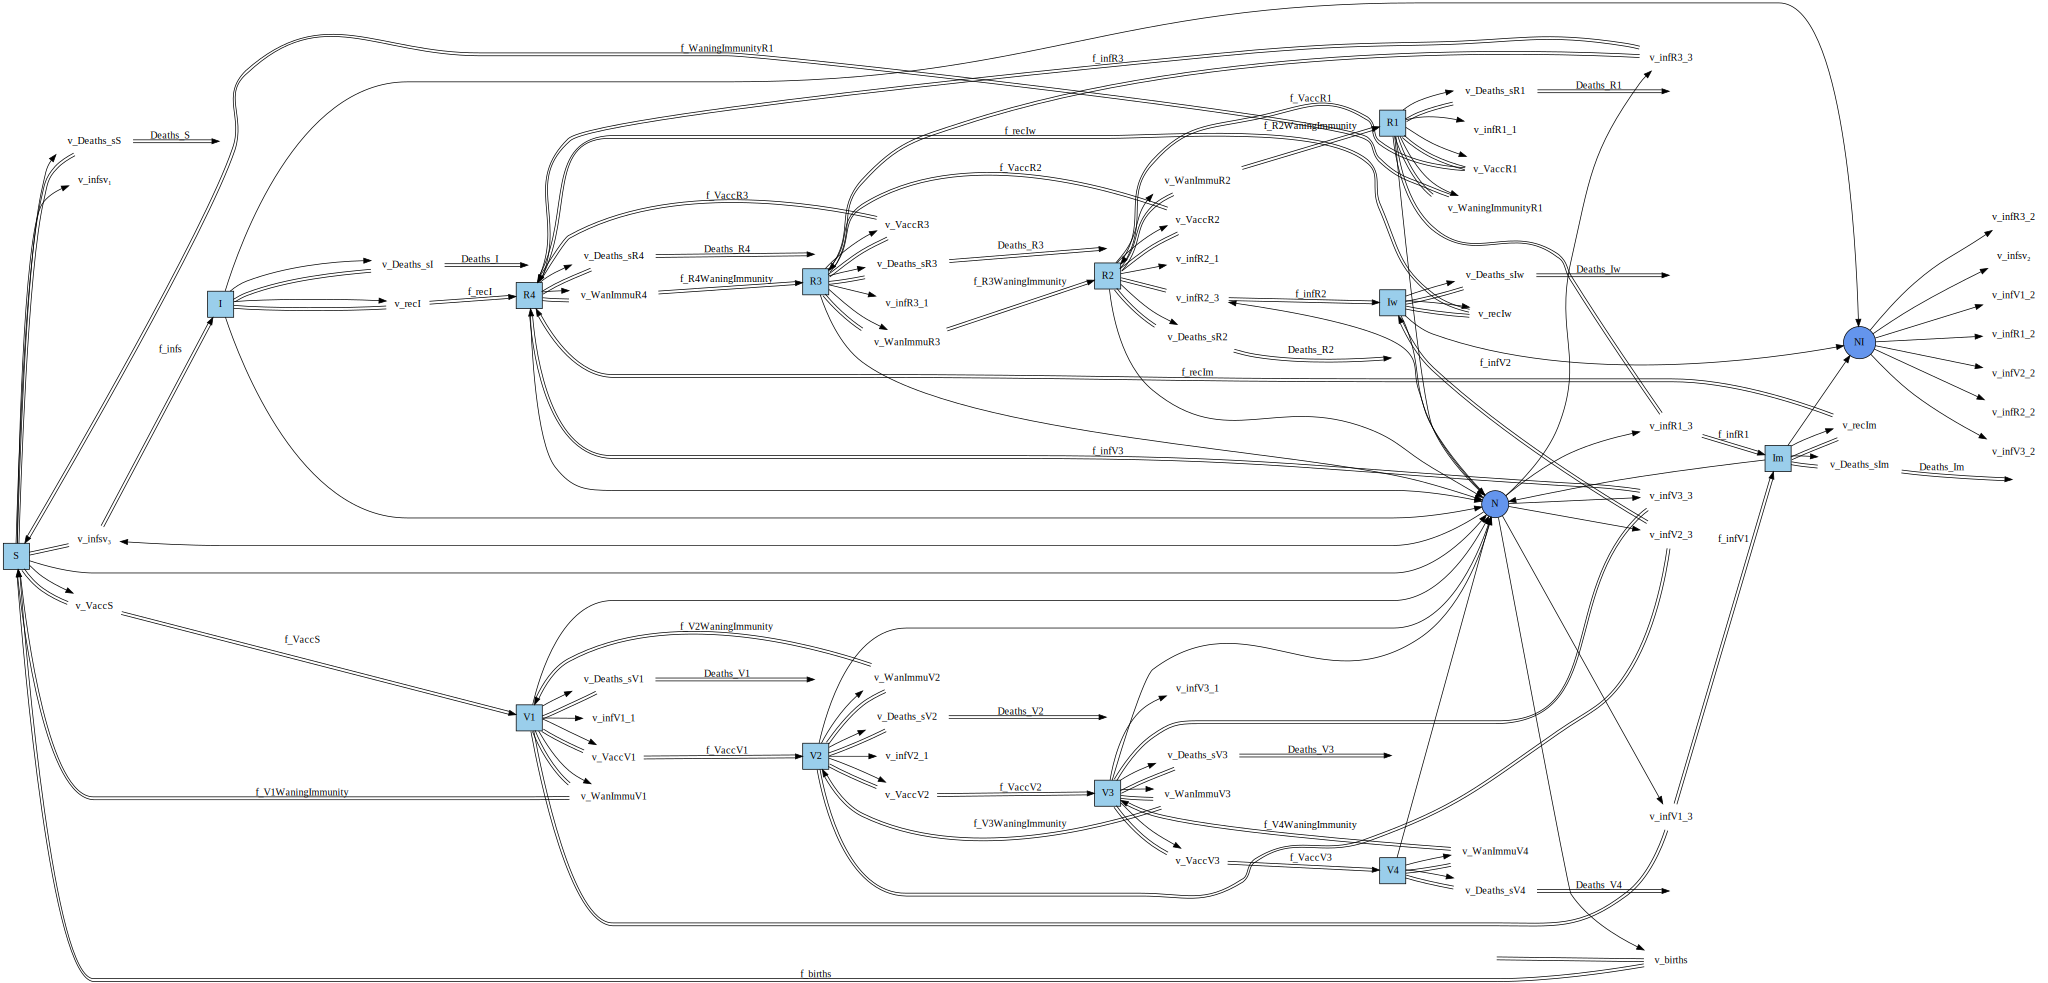

In [54]:
pertussis_model = oapply(pertussis_uwd,Dict(
    :SD=>fOpenDeaths("S"),
    :ID=>fOpenDeaths("I"),
    :ImD=>fOpenDeaths("Im"),
    :IwD=>fOpenDeaths("Iw"),
    :V1D=>fOpenDeaths("V1"),
    :V2D=>fOpenDeaths("V2"),
    :V3D=>fOpenDeaths("V3"),
    :V4D=>fOpenDeaths("V4"),
    :R1D=>fOpenDeaths("R1"),
    :R2D=>fOpenDeaths("R2"),
    :R3D=>fOpenDeaths("R3"),
    :R4D=>fOpenDeaths("R4"),
    :SIR4=>openSIR,
    :V1R1ImR4=>openVRIR("1","m"),
    :V2R2IwR4=>openVRIR("2","w"),
    :R1R2=>fOpenImmunity("R1","R2",:α),
    :R2R3=>fOpenImmunity("R2","R3",:α),
    :R3R4=>fOpenImmunity("R3","R4",:α),
    :SV1=>fOpenImmunity("S","V1",:ϵ),
    :V1V2=>fOpenImmunity("V1","V2",:τ),
    :V2V3=>fOpenImmunity("V2","V3",:τ),
    :V3V4=>fOpenImmunity("V3","V4",:τ),
    :R3R4I=>fOpenR3OrV3ToR4("R3"),
    :V3R4I=>fOpenR3OrV3ToR4("V3"),
    :R1S=>OpenR1ToS
    )) |> apex
Graph(pertussis_model)

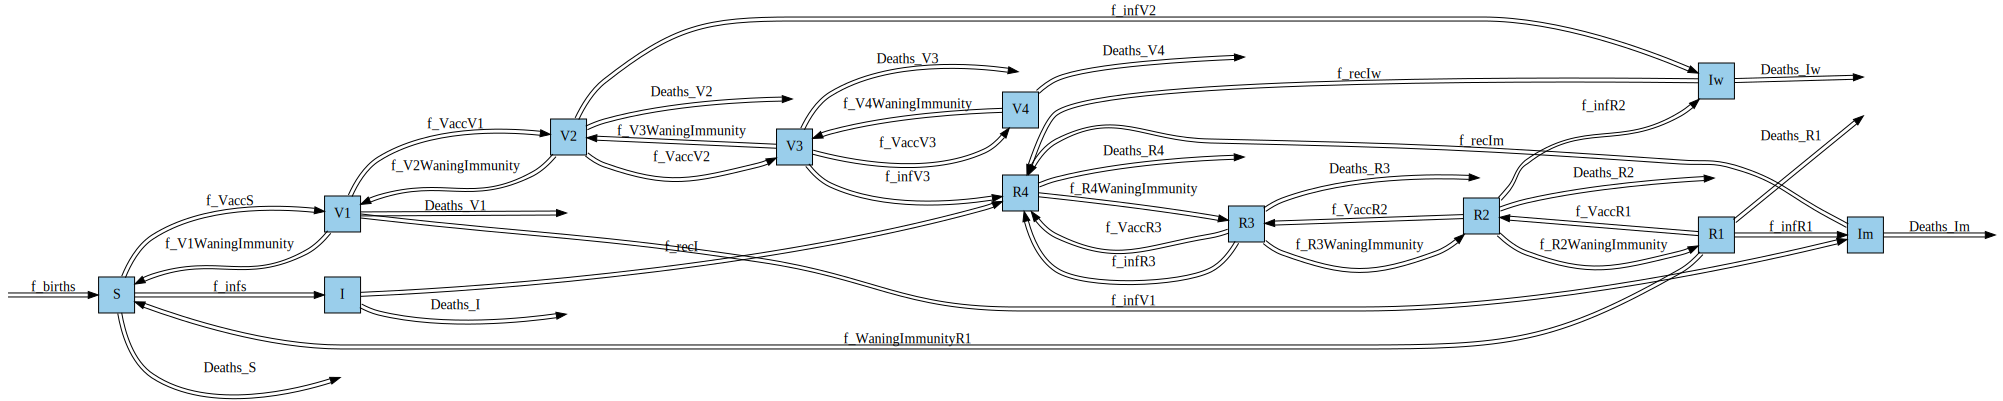

In [55]:
Graph(pertussis_model,type="SF")

# Solve ODEs

In [56]:
# define values of constant parameters
p = LVector(
    β=0.184, rBirth=30*0.32/365.0, rDeath=30*0.32/365.0, ϵ=30.0 * 0.01 / 365.0, 
    vacc=1.0/4.0, α=30.0 * 1.0 / (5 * 365), τ=30.0 * 1.0 / (2 * 365), γ=30.0 * 1.0 / 21
)
# define initial values for stocks
u0 = LVector(
    S=863544.0, I=10.0, Im=0.0, Iw=0.0,
    R1=0.0, R2=0.0, R3=0.0, R4=0.0,
    V1=0.0, V2=0.0, V3=0.0, V4=0.0
)

12-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :Im, :Iw, :R1, :R2, :R3, :R4, :V1, :V2, :V3, :V4)}:
  :S => 863544.0
  :I => 10.0
 :Im => 0.0
 :Iw => 0.0
 :R1 => 0.0
 :R2 => 0.0
 :R3 => 0.0
 :R4 => 0.0
 :V1 => 0.0
 :V2 => 0.0
 :V3 => 0.0
 :V4 => 0.0

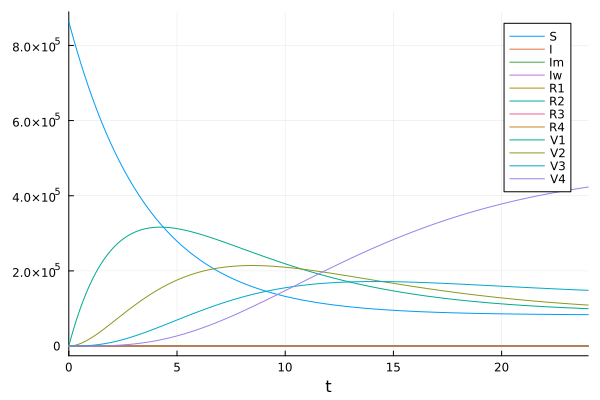

In [57]:
# results are tested the same as the Anylogic model
prob_pertussis = ODEProblem(vectorfield(pertussis_model),u0,(0.0,24.0),p);
sol = solve(prob_pertussis,Tsit5(),abstol=1e-8);
plot(sol)

In [58]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")